In [67]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.nn import ReLU
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torchvision import models




# There were issues with my certificate
import ssl
import certifi

ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())


### Dataset Loading and Data Processing
Here we load the CIFAR10 dataset

In [68]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

# batch_size = 4 # In the powerpoint slides it is 32?

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [69]:
# #functions to show an image
# def imshow(img):
# 	img = img / 2 + 0.5 # unnormalize
# 	npimg = img.numpy()
# 	plt.imshow(np.transpose(npimg, (1,2,0)))
# 	plt.show()


# #get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
def get_device():
	if torch.cuda.is_available():
		return torch.device ('cuda' )
	elif torch.backends.mps.is_available():
		return torch.device ('mps')
	else:
		return torch.device('cpu')
	
device = get_device()	


def preprocess_data(transformations, batch_size, subset_size=24000):
	"""
	This function creates dataloaders with model-specific transformations for data preprocessing
	"""
	# Load the full training dataset
	full_train_set = torchvision.datasets.CIFAR10(
		root='./data', 
		train=True, 
		download=True, 
		transform=transformations
	)	

	# Creating a subset of the training data
	if subset_size and subset_size < len(full_train_set):
		# Creates a random subset
		indices = torch.randperm(len(full_train_set))[:subset_size]
		train_dataset = Subset(full_train_set,indices)
	else:
		train_dataset = full_train_set

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformations)
	test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

	# Should we return train_set and test_loader too?
	return train_loader, test_loader

### Defining our CNNs
***
We will be experimenting with various pre-trained Deep CNNs - specifically ResNet and VGG architectures.

We will be using 2 different versions of Resnet and 2 different versions of VGG.

VGG: We will be using models `vgg11` , `vgg11_bn` (with batch normalization), `vgg19`, `vgg19_bn`

RESNET: We will be using `resnet18` (ResNet-18) and `resnet152` (ResNet-152)

** apply its specific preprocessing transformations to  CIFAR-10 dataset when creating DataLoader objects. **

For each model we use, we will:
1. Import, insantiate, and load it with default, pretrained weights
2. Get the correct preprocessing transformations for that specific model
3. Apply those transformations to our CIFAR10 dataset
4. Modify the classifer part of the model for our 10-class classification task.
-> this means that we need to freeze the ConvLayer(s) parts of the network, and modify the last couple layers -- follow Lecture 9 examples.


In [71]:
model = models.vgg16().to(device)


# summary(model.to(device), (3, 224, 224))

def better_summary(model, input_size, batch_size=32):
	"""
	A better summary function that ensures device consistency between weights used for the VGG model
	"""
	
	# Get the device the model is on
	model_on_cpu = model.to('cpu')
	summary(model_on_cpu, input_size, batch_size=batch_size)
	# Move model back to original device
	model.to(device)

better_summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [72]:
from torchvision.models import resnet18, resnet152, ResNet18_Weights, ResNet152_Weights
from torchvision.models import vgg11, vgg11_bn, vgg19, vgg19_bn, VGG11_Weights, VGG19_Weights

batch_size = 32
# Load ResNet models with pretrained weights
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet152_model = resnet152(weights=ResNet152_Weights.DEFAULT)

# Load VGG models with pretrained weights for transfer learning
vgg11_model = vgg11(weights=VGG11_Weights.DEFAULT)
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)

# Get transformations for every model
resnet18_transforms = ResNet18_Weights.DEFAULT.transforms()
resnet152_transforms = ResNet152_Weights.DEFAULT.transforms()
vgg11_transforms = VGG11_Weights.DEFAULT.transforms()
vgg19_transforms = VGG19_Weights.DEFAULT.transforms()

models = [vgg11_model]


# Create dataloaders for each model with its specific transforms
resnet18_train_loader, resnet18_test_loader = preprocess_data(resnet18_transforms, batch_size=batch_size)
resnet152_train_loader, resnet152_test_loader = preprocess_data(resnet152_transforms, batch_size=batch_size)
vgg11_train_loader, vgg11_test_loader = preprocess_data(vgg11_transforms, batch_size=batch_size)
vgg19_train_loader, vgg19_test_loader = preprocess_data(vgg19_transforms, batch_size=batch_size) 
list_of_transformations = [resnet18_transforms, resnet152_transforms, vgg11_transforms, vgg19_transforms]

for model in models:
	better_summary(model.to(device), (3, 224, 224))
	# print(model)
	for param in model.features.parameters():
		param.requires_grad = False # Freezing these layers

	model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
	model.classifier = nn.Sequential(nn.Flatten(),
								  	nn.Linear(512, 128),
									nn.ReLU(), # Activation between linear layers
									nn.Dropout(0.2),
								 	nn.Linear(128, 10))
	
	better_summary(model.to(device), (3, 224, 224))

	


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
         MaxPool2d-3         [32, 64, 112, 112]               0
            Conv2d-4        [32, 128, 112, 112]          73,856
              ReLU-5        [32, 128, 112, 112]               0
         MaxPool2d-6          [32, 128, 56, 56]               0
            Conv2d-7          [32, 256, 56, 56]         295,168
              ReLU-8          [32, 256, 56, 56]               0
            Conv2d-9          [32, 256, 56, 56]        

### Training, Experimentation and Transfer Learning

Doing transfer learning on ResNet is slightly different from VGG (the layers don't have the same names), so we print the networks to know which layers to freeze.

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_batch(model, opt, loss_fn, x, y):
	model.train()
	
	opt.zero_grad()
	batch_loss = loss_fn(model(x), y) # Loss
	batch_loss.backward() # Compute gradients
	opt.step() # Make a GD step

	return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def accuracy(model, x, y,):
	model.eval()
	prediction = model(x)
	argmaxes = prediction.argmax(dim=1)
	s = torch.sum((argmaxes == y).float()/len(y))
	return s.cpu().numpy()

def perform_training(dataloader=vgg11_train_loader):
	"""
	"""
	train_losses, train_accuracies, n_epochs = [], [], 5
	for epoch in range(n_epochs):
		print(f"Running epoch {epoch + 1} of {n_epochs}")

		train_epoch_losses, train_epoch_accuracies = [], []
		
		# for x, y in dataloader:
		# 	x,y = x.to(device), y.to(device)
		# 	loss = train_batch(model, optimizer, loss_fn, x, y)
		# 	train_epoch_losses
		train_epoch_losses = [train_batch(model, optimizer, loss_fn, x=x.to(device), y=y.to(device)) for x, y in vgg11_train_loader]
		train_epoch_loss = np.mean(train_epoch_losses)

		train_epoch_accuracies = [accuracy(model, x=x.to(device), y=y.to(device)) for x, y in vgg11_train_loader]
		train_epoch_accuracy = np.mean(train_epoch_accuracies)

		train_losses.append(train_epoch_loss)
		train_accuracies.append(train_epoch_accuracy)
	return train_losses, train_accuracies
	


Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
0.52534175
0.49750644
0.4744167
0.45134777
0.44018736


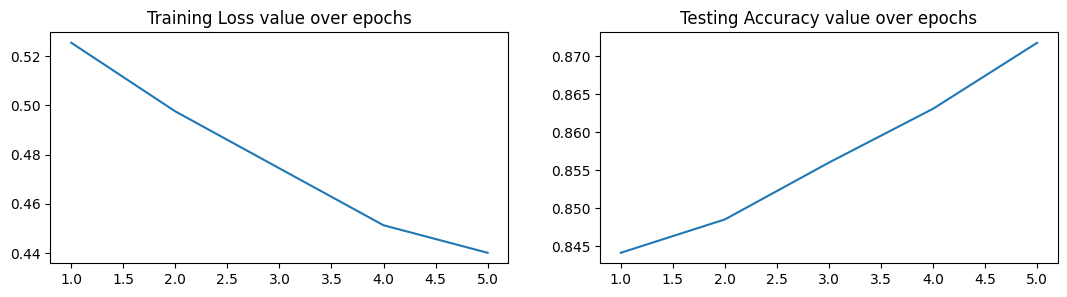

In [77]:
import matplotlib.pyplot as plt

train_losses, train_accuracies = perform_training(models[0])
n_epochs = 5

for loss in train_losses:
	print(loss)

plt.figure(figsize=(13,3))
plt.subplot(121)
plt.title('Training Loss value over epochs')
plt.plot(np.arange(n_epochs) + 1, train_losses)
plt.subplot(122)
plt.title('Testing Accuracy value over epochs')
plt.plot(np.arange(n_epochs) + 1, train_accuracies)
